A diffusion probabilistic model is a parameterized Markov Chain trained using variational inference to produce samples matching the data after finite time.

This `parameterization` exists in the reverse sense, such that the transitions of this Markov Chain are learnt in order to reverse a diffusion process.

## Difference from other types of Models -

What distinguishes diffusion models from other types of latent variable models is that the approximate posterior `q(x_{1:T}|x_0)`, called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β_{1},...,β_{T}.


The variance schedule can either be sequentially computed, which WILL SPAN a lot of time in the forward process, or as an alternative approximation, it can be kept as a hyperparameter, pre-computed.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Three components needed to Implement the Diffusion Model :

(A) NOISE SCHEDULER :
Responsible for sequentially adding noise to the input data. (In our case, multi-channel calorimetry hits flattened out in a 2D grid)

(B) NEURAL NETWORK :
To predict the noise in an image.

(C) TIMESTEP ENCODING :
A way to encode the current timestep.

In [ ]:
import numpy as np
import h5py

def load_h5(file_name, size):
    # Load the dataset from the HDF5 file
    with h5py.File(file_name, 'r') as f:
        X = np.array(f['X_jets'][:size])
        y = np.array(f['y'][:size])
    return X, y


In [ ]:
file = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'
size = 10000
X, y = load_h5(file, size)

In [ ]:
# Count occurrences of each value (0s and 1s)
y_int = y.astype(np.int64)
counts = np.bincount(y_int)

# Create a dictionary to store counts
counts_dict = {'0': counts[0], '1': counts[1]}

print(counts_dict)

{'0': 4994, '1': 5006}


In [ ]:
from skimage.transform import resize
def data_preprocess(X_jets):
    #Normalizing the images

    # Resizing images from (125, 125, 3) to (128, 128, 3)
    resized_images = np.zeros((X_jets.shape[0], 128, 128, 3), dtype=np.float32)
    for i in range(X_jets.shape[0]):
        resized_images[i] = resize(X_jets[i], (128, 128), anti_aliasing=True)

    X_jets = resized_images
    del resized_images

    # Normalizing the entire image across all channels
    mean = np.mean(X_jets)
    std = np.std(X_jets)
    X_jets = (X_jets - mean) / std

    # Assuming X_jets is your image array
    X_jets = np.clip(X_jets, 0, None)
    # X_jets[:,:,:,0] = X_jets[:,:,:,0]/np.max(X_jets[:,:,:,0])
    # X_jets[:,:,:,1] = X_jets[:,:,:,1]/np.max(X_jets[:,:,:,1])
    # X_jets[:,:,:,2] = X_jets[:,:,:,2]/np.max(X_jets[:,:,:,2])

    return X_jets

In [ ]:
X_jets = data_preprocess(X)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_combined_channels(dataset):
    # Extracting the initial 5 jet images from the dataset...
    images = dataset[:5]

    for i in range(5):
        X_sample = images[i]
        og_plot = plt.imshow(X_sample)


        fig, axs = plt.subplots(1, 3, figsize=(20, 20))

        im1 = axs[0].imshow(X_sample[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axs[0].set_title(f'Track for {i}th image')

        im2 = axs[1].imshow(X_sample[:, :, 1], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axs[1].set_title(f'ECAL for {i}th image')

        im3 = axs[2].imshow(X_sample[:, :,2], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axs[2].set_title(f'HCAL for {i}th image')

        # Add colorbars
        fig.colorbar(im1, ax=axs[0], shrink=0.25)
        fig.colorbar(im2, ax=axs[1], shrink=0.25)
        fig.colorbar(im3, ax=axs[2], shrink=0.25)

        plt.show()

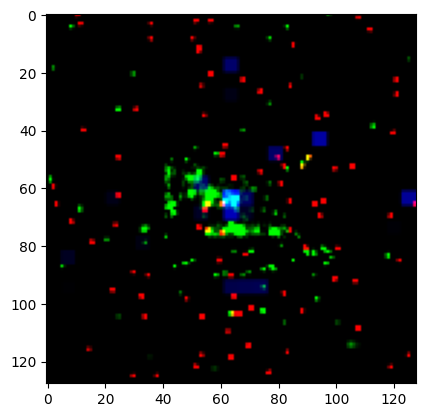

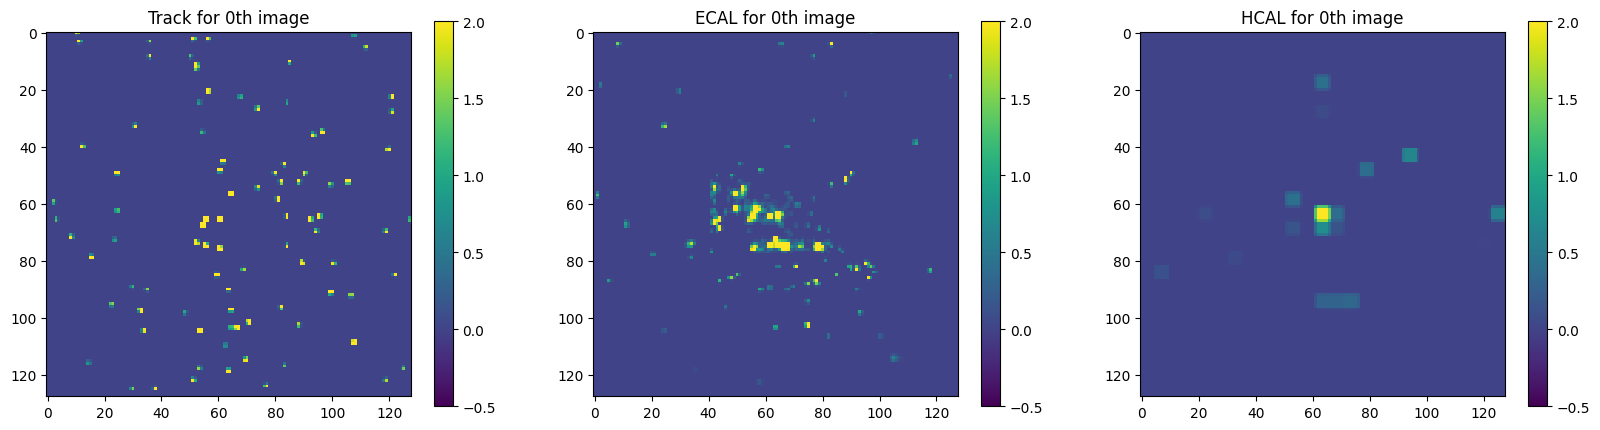

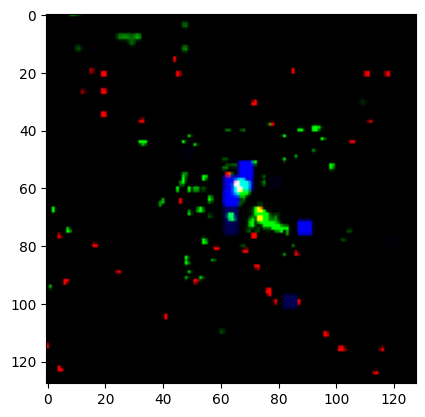

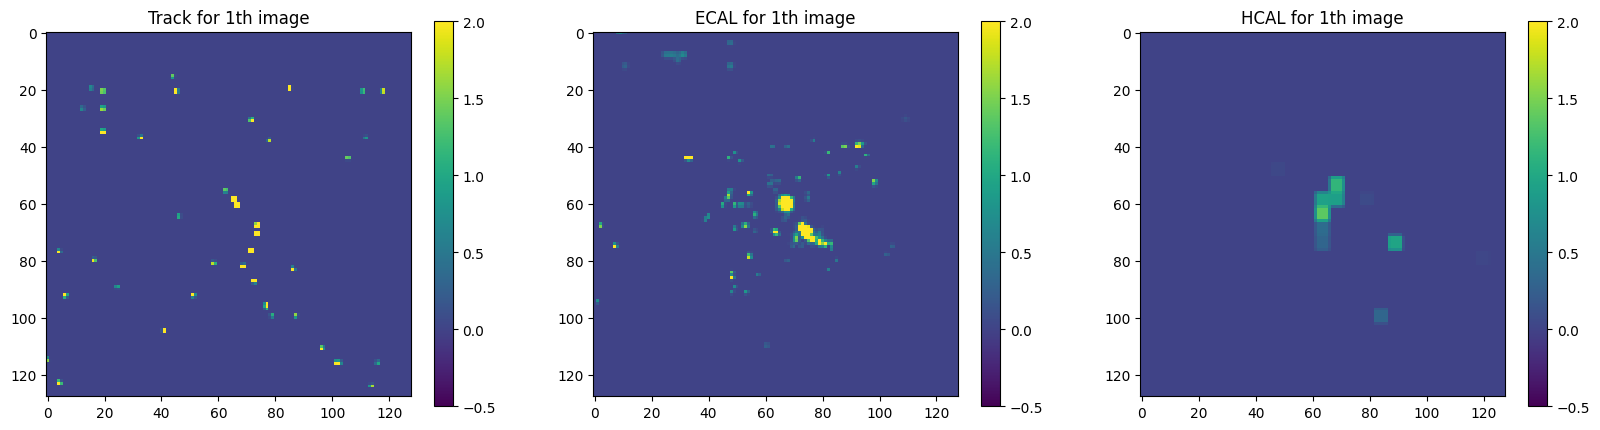

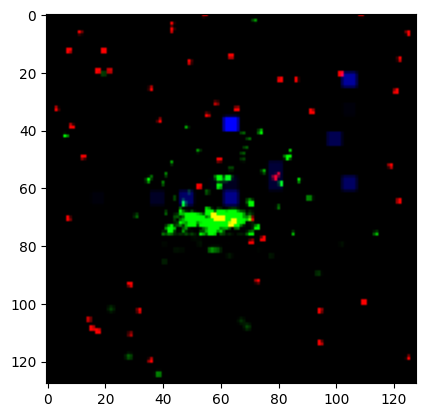

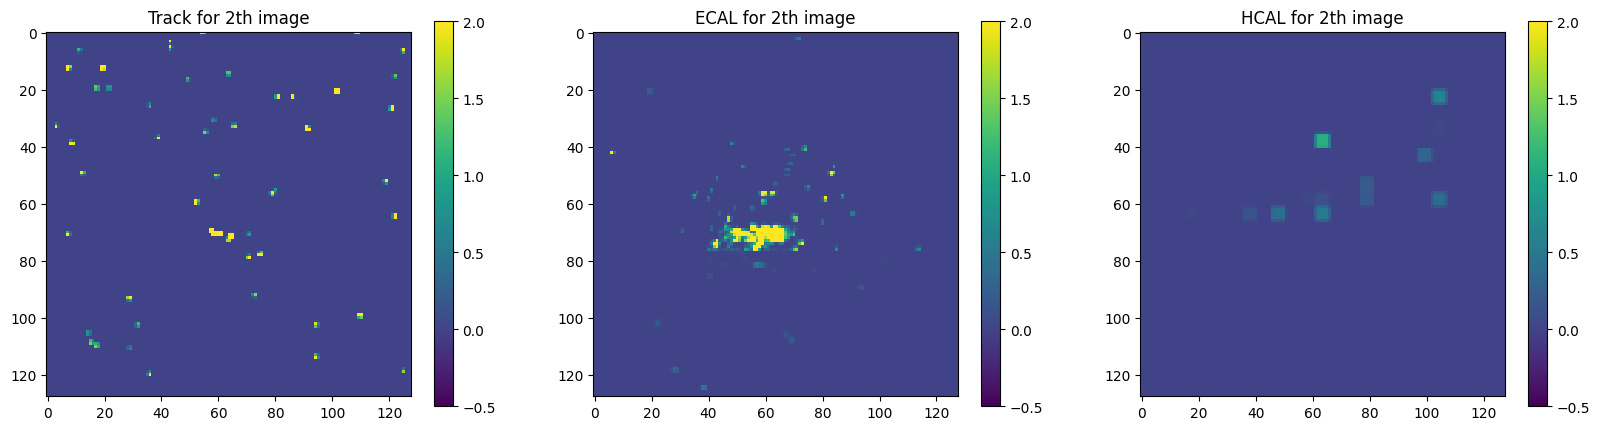

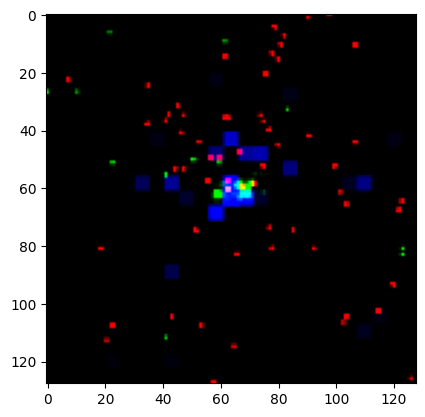

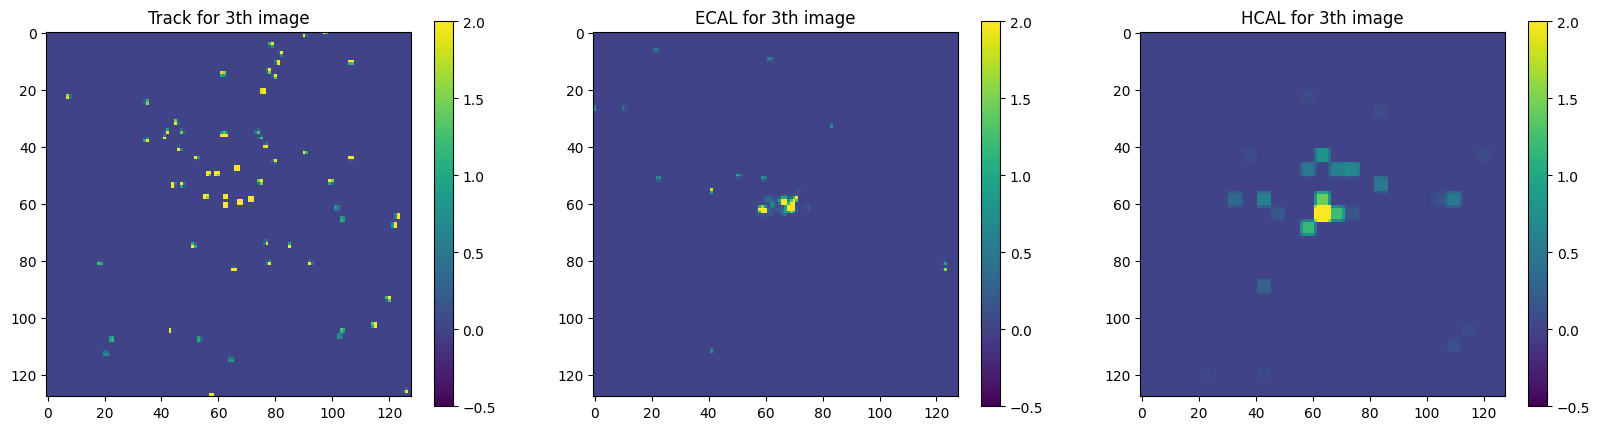

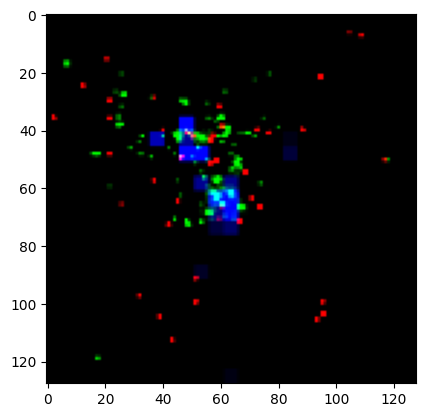

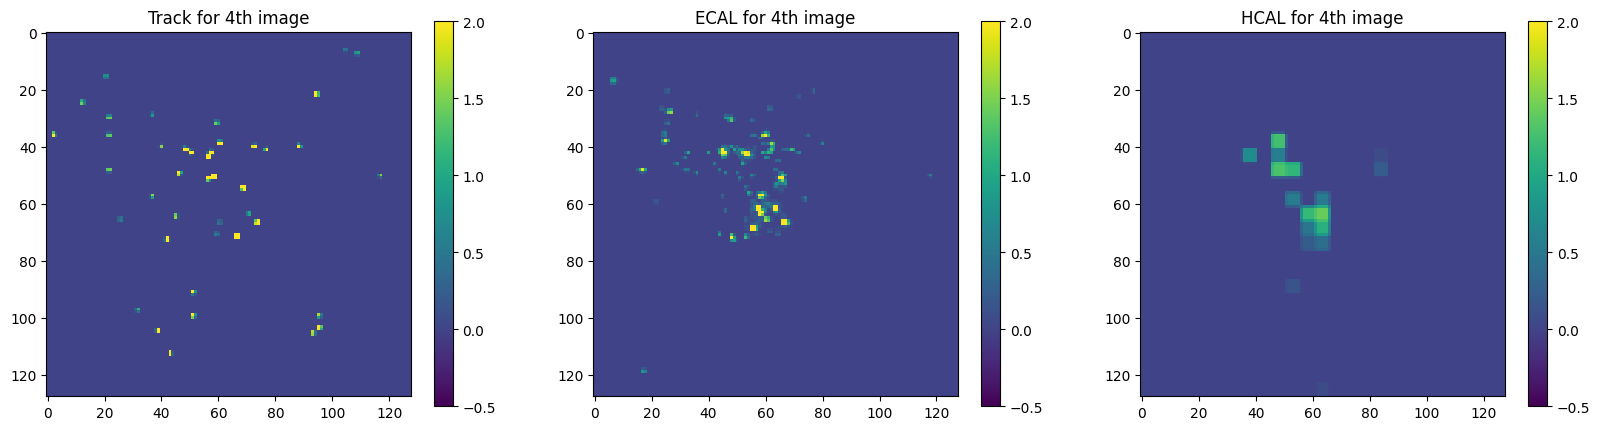

In [ ]:
plot_images_with_combined_channels(X_jets)

## Part : 1 ->   NOISE SCHEDULER

We need to build up a Markovian chain of inputs for the model. i.e., generate increasingly noise jet images. The paper <href>https://arxiv.org/pdf/2006.11239.pdf </href> Provides a closed form to calculate the image for any of the timesteps individually (pre-computation assuming conditional independence).

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

""" Helper functions to fecilitate the forward diffusion Markov Chain..."""

# To generate a linear schedule of timesteps based on our specified start and end timestamps.

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

# Fetch the values corresponding to a certain specified indices.
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """

    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())

    # Dimensionality remains constant across transitions. We need a tensor corresponding to the original tensor.
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
## X_jets[:,:,:,0] = X_jets[:,:,:,0]/np.max(X_jets[:,:,:,0])
# X_jets[:,:,:,1] = X_jets[:,:,:,1]/np.max(X_jets[:,:,:,1])
# X_jets[:,:,:,2] = X_jets[:,:,:,2]/np.max(X_jets[:,:,:,2])

<ipython-input-11-bd1deb6a7273>:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


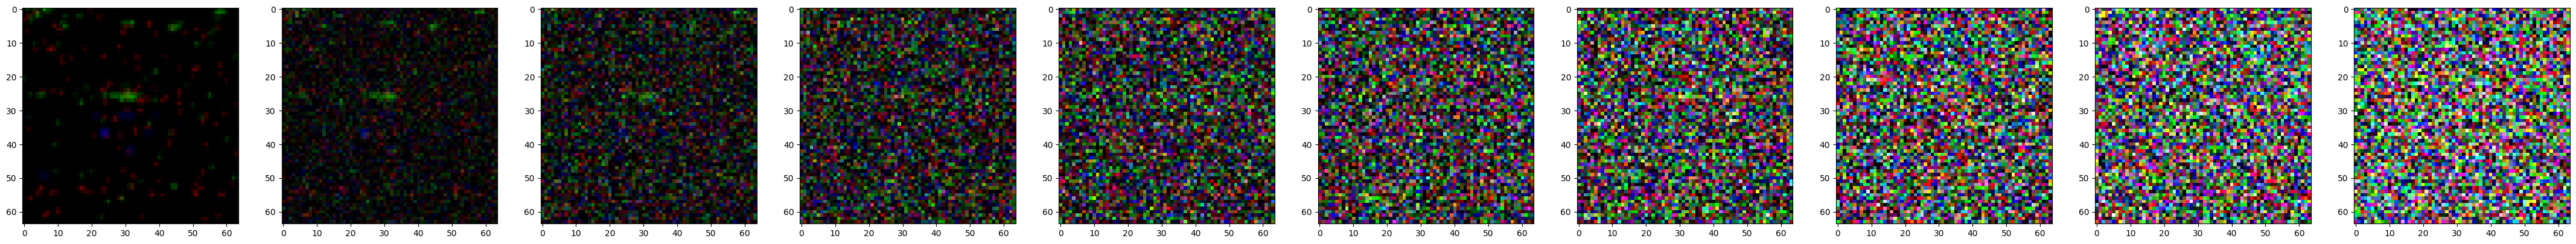

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pil_to_tensor

# Define the transformation pipeline
data_transforms = [
    transforms.Resize((64, 64)), # Resize to 64x64
    transforms.ToTensor(), # Convert to tensor
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]
data_transform = transforms.Compose(data_transforms)

# Converting numpy.ndarray to Tensor and applying transformations, we get
X_jets_tensor = torch.stack([data_transform(transforms.ToPILImage()(X_jets[i])) for i in range(X_jets.shape[0])])

# Creating a DataLoader
BATCH_SIZE = 256
dataloader = DataLoader(TensorDataset(X_jets_tensor), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Simulate forward diffusion
image = next(iter(dataloader))[0]

# Visualize the images
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # (C,H,W) to (H,W,C)
        transforms.Lambda(lambda t: t.numpy().astype(np.float32)),
#        transforms.ToPILImage(),
    ])

    # Taking the first image of the created batch,
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    image = reverse_transforms(image)
    plt.imshow(image, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')

plt.figure(figsize=(60,60))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t) # Assuming forward_diffusion_sample is defined elsewhere
    show_tensor_image(img)


We can see, our Sequential Noise addition functions are working as intended, step-wise adding Gaussian Noise sampled from pre-computed distributions (with mean and std. dev. calculated from the initial image).

In [ ]:
X_jets_tensor.shape

torch.Size([10000, 3, 64, 64])

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
training_size = int(0.7 * X_jets_tensor.shape[0])
testing_size = int(X_jets_tensor.shape[0]) - training_size

train_set, test_set = random_split(X_jets_tensor, [training_size, testing_size])

train_loader = DataLoader(train_set, batch_size = 256, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 256, shuffle = True)

Now, we need to create a Neural Network that will act as a predictor of added noise in the Jet Images.

In [ ]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, kernel_size = 3, padding = 1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size = 4, stride = 2, padding = 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size = 4,  stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 64

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [ ]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62534147


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=64, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=64, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [ ]:
# Defining the loss function (For now, use L1 Loss..)

# TODO : Experiment with L2 Loss function ...

def get_loss(model, x_0, t):
   # print(x_0.shape)
   # print(t.shape)
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 64
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(50,50))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [ ]:
for step, batch in enumerate(train_loader):
  print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
from tqdm import tqdm

In [ ]:
import torch
torch.cuda.is_available()

True

Epoch 0/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 0.8109683394432068 


<ipython-input-17-689aba249e6e>:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


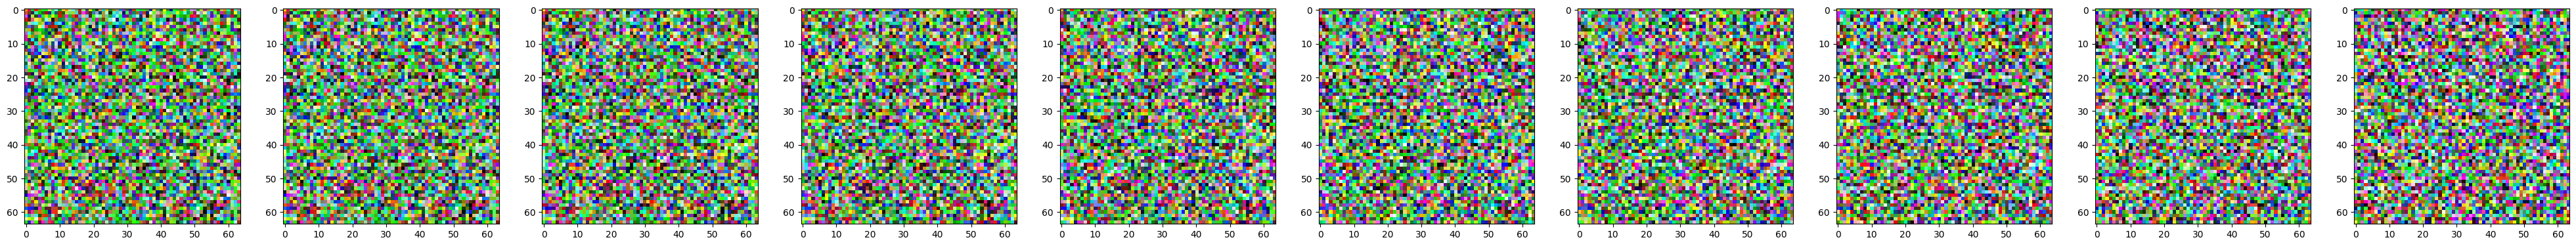

Epoch 5/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 | step 000 Loss: 0.4619099497795105 


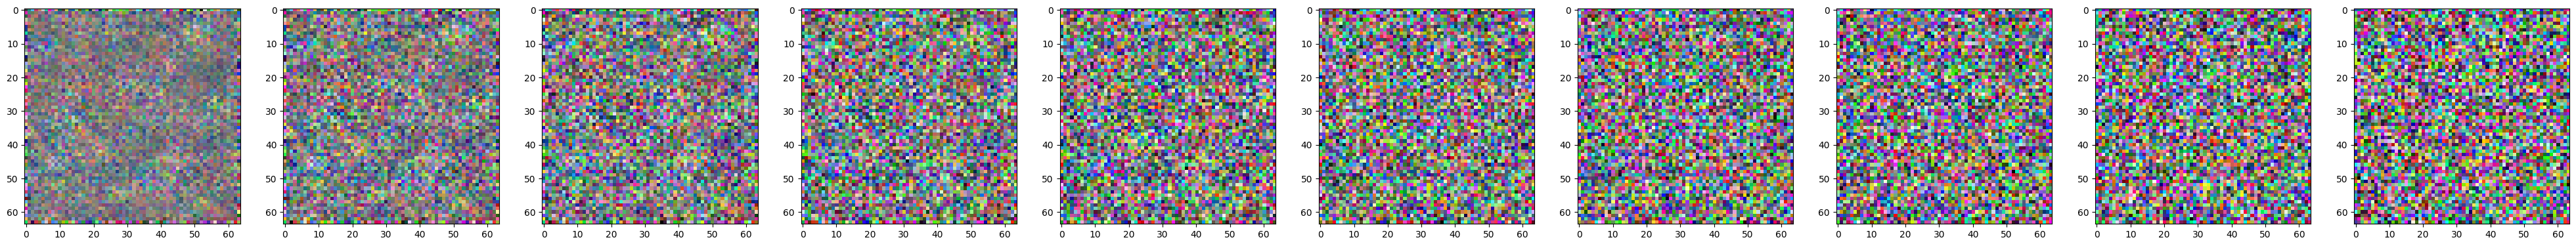

Epoch 10/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 | step 000 Loss: 0.30502408742904663 


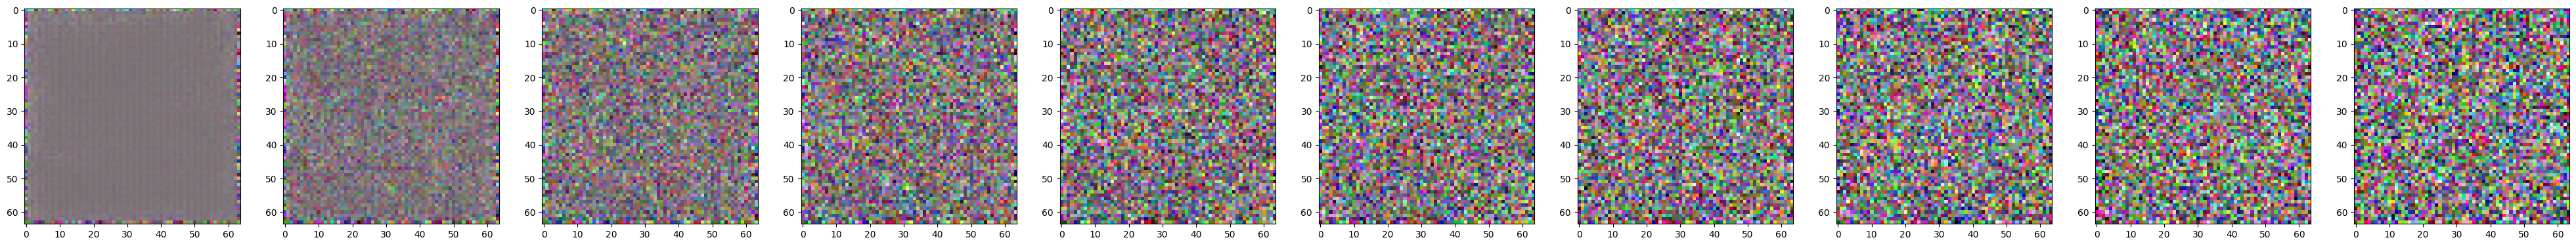

Epoch 15/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15 | step 000 Loss: 0.25287291407585144 


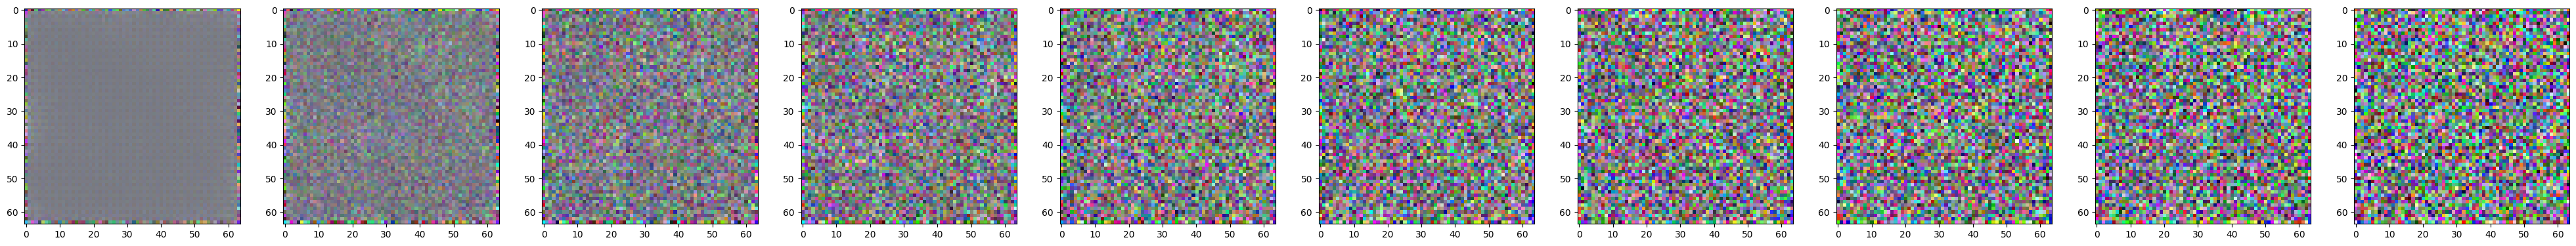

Epoch 20/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20 | step 000 Loss: 0.2607686221599579 


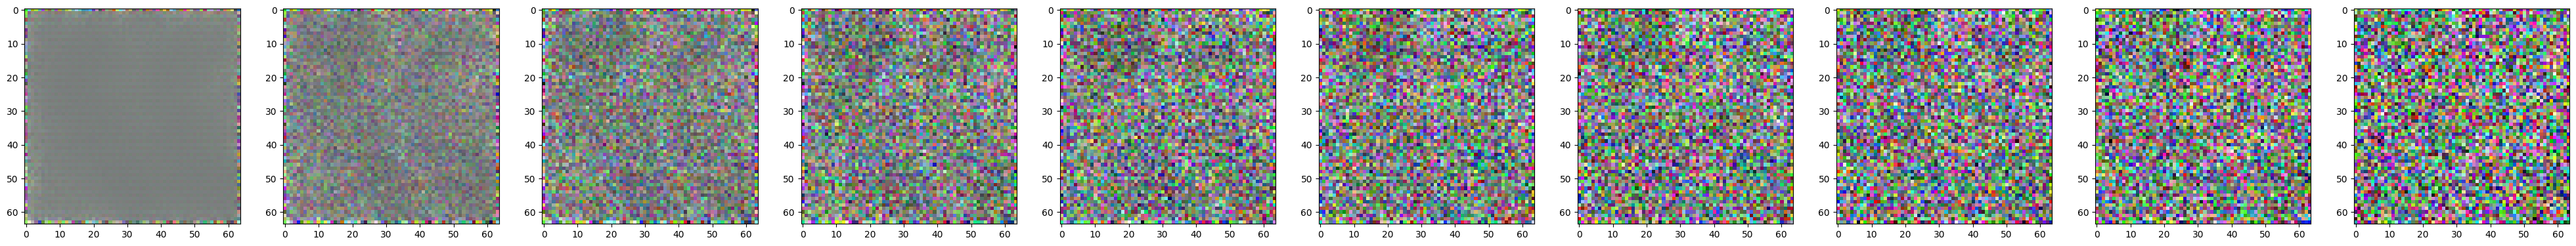

Epoch 25/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25 | step 000 Loss: 0.19995880126953125 


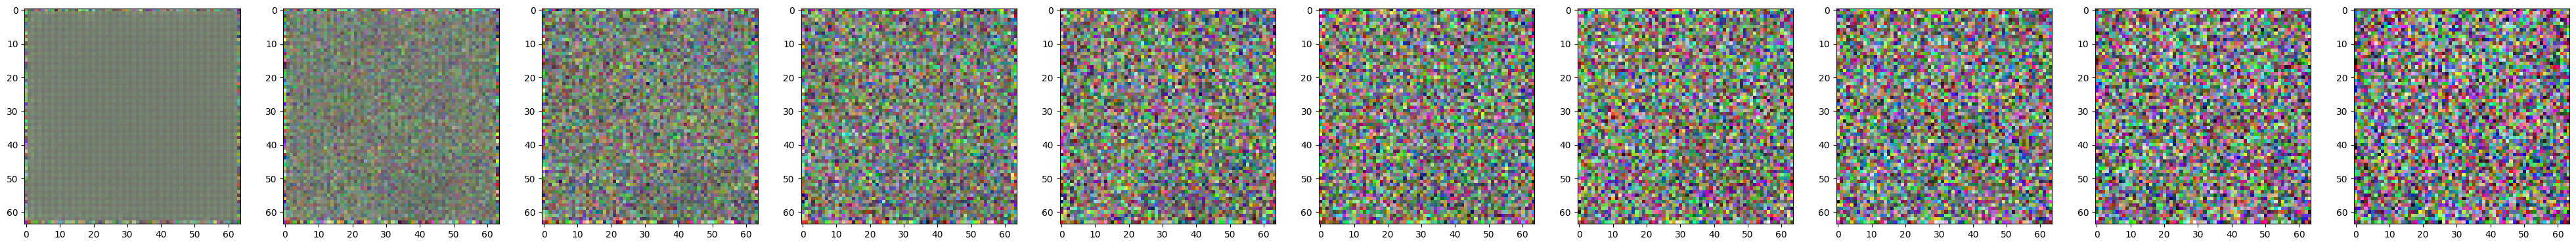

Epoch 30/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30 | step 000 Loss: 0.19434309005737305 


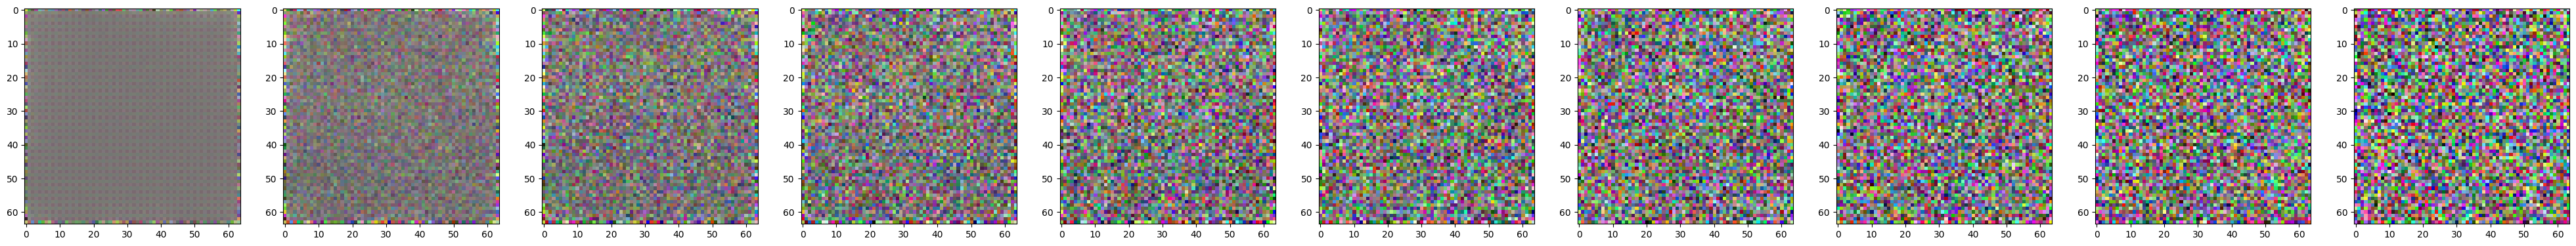

Epoch 35/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 35 | step 000 Loss: 0.1874413937330246 


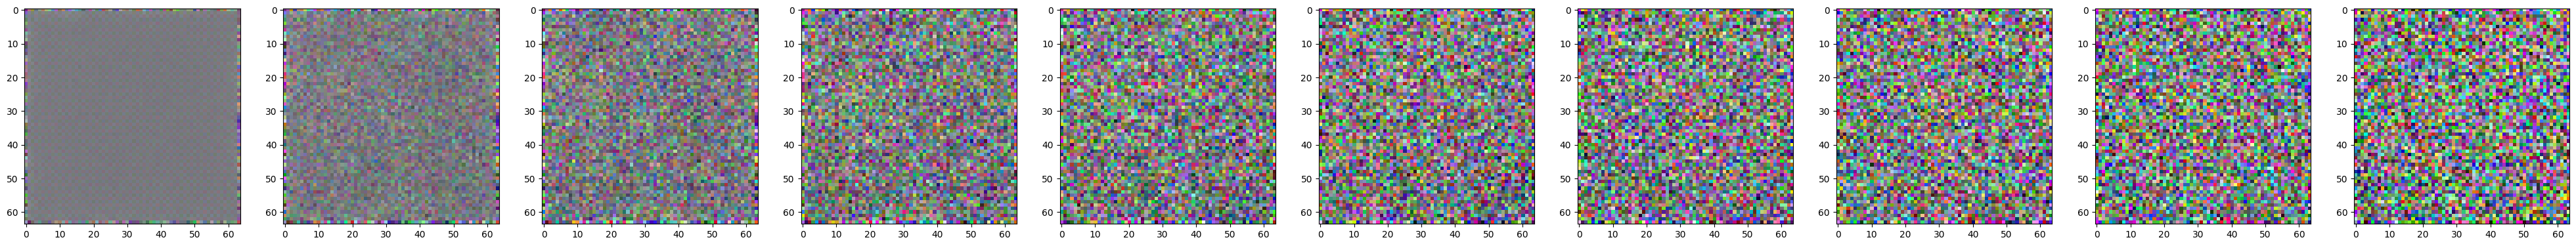

Epoch 40/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 40 | step 000 Loss: 0.17758288979530334 


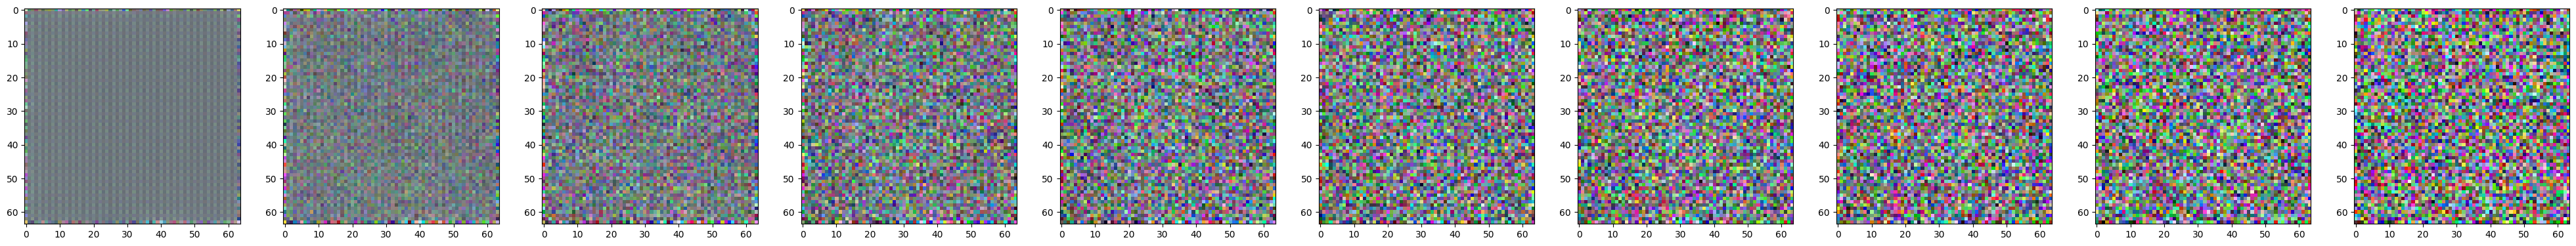

Epoch 45/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 45 | step 000 Loss: 0.16500841081142426 


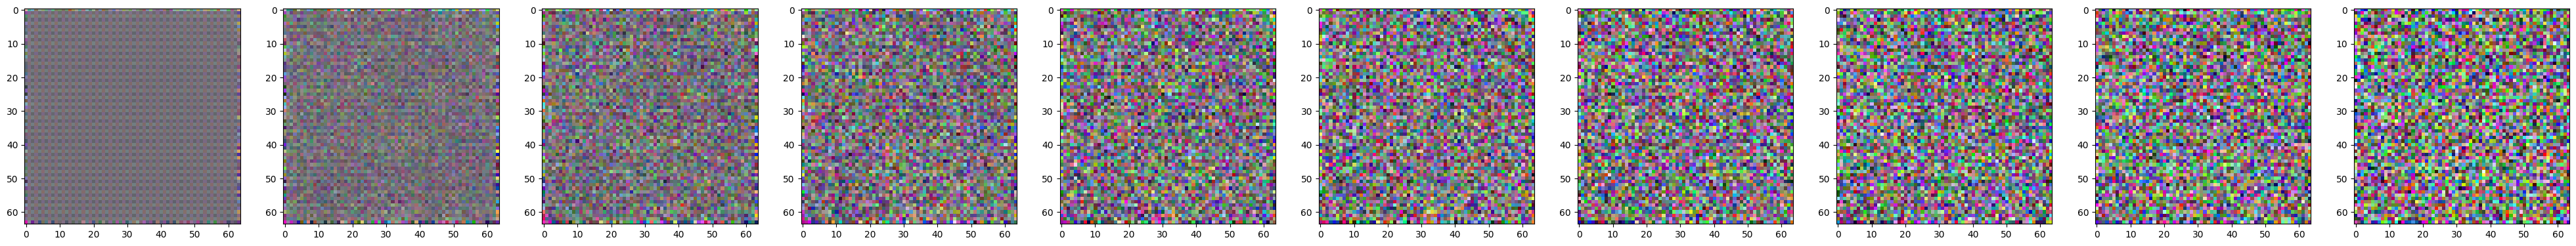

Epoch 50/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 50 | step 000 Loss: 0.15028676390647888 


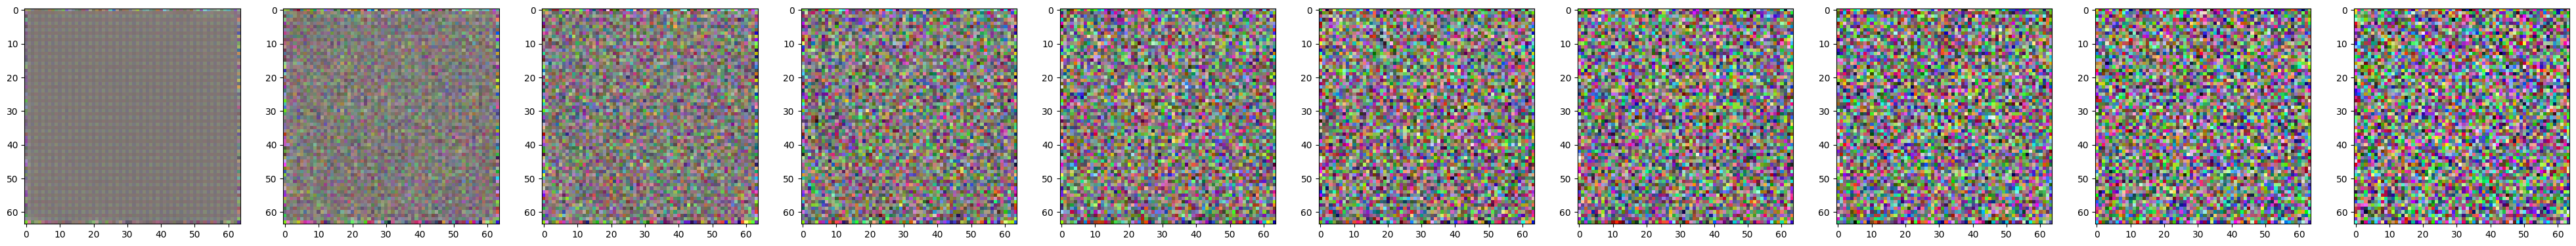

Epoch 55/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 55 | step 000 Loss: 0.16051319241523743 


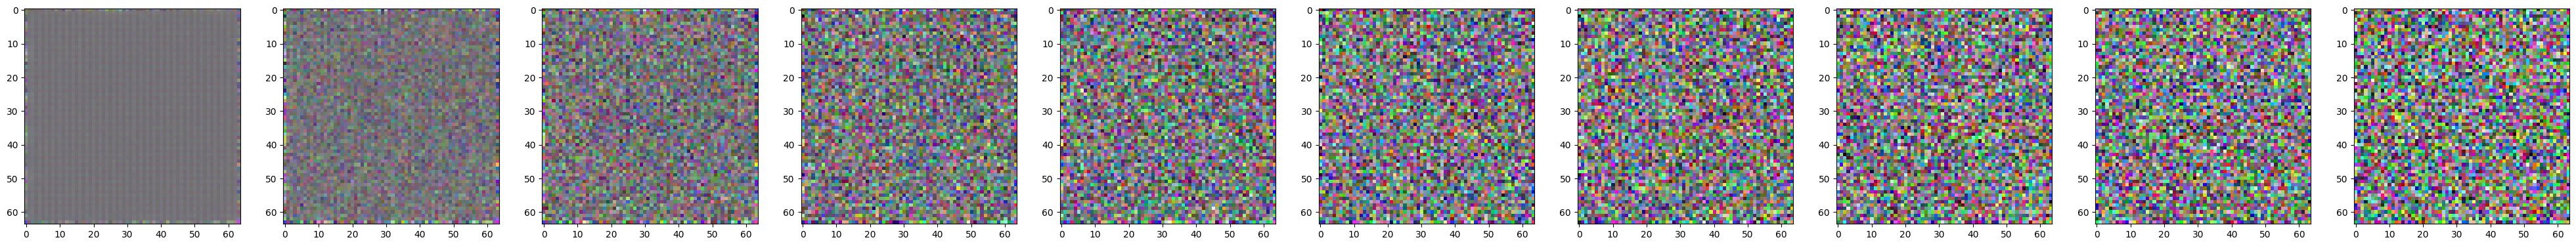

Epoch 60/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 60 | step 000 Loss: 0.1326962411403656 


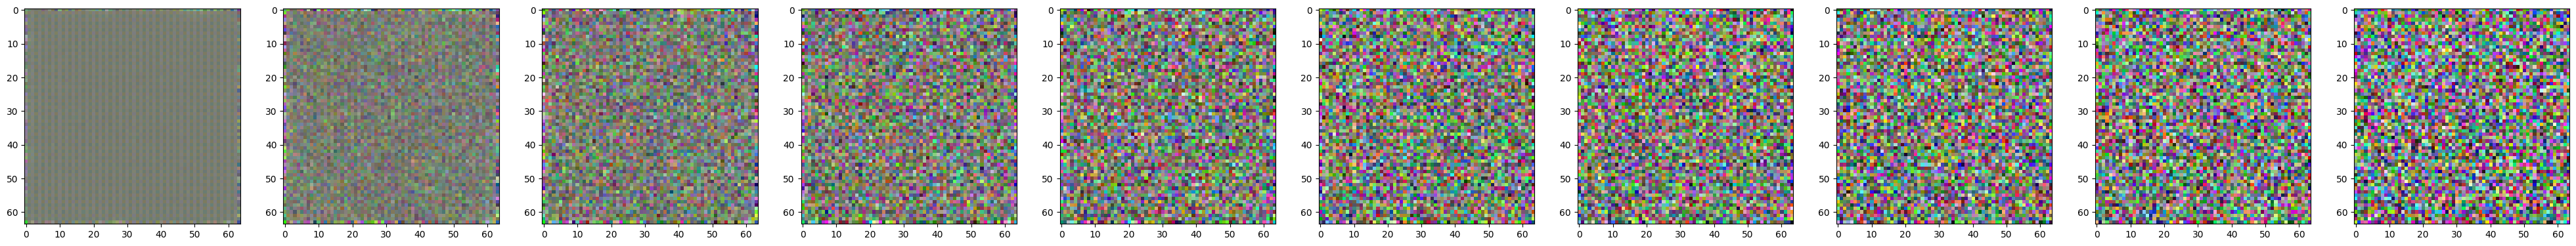

Epoch 65/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 65 | step 000 Loss: 0.13496144115924835 


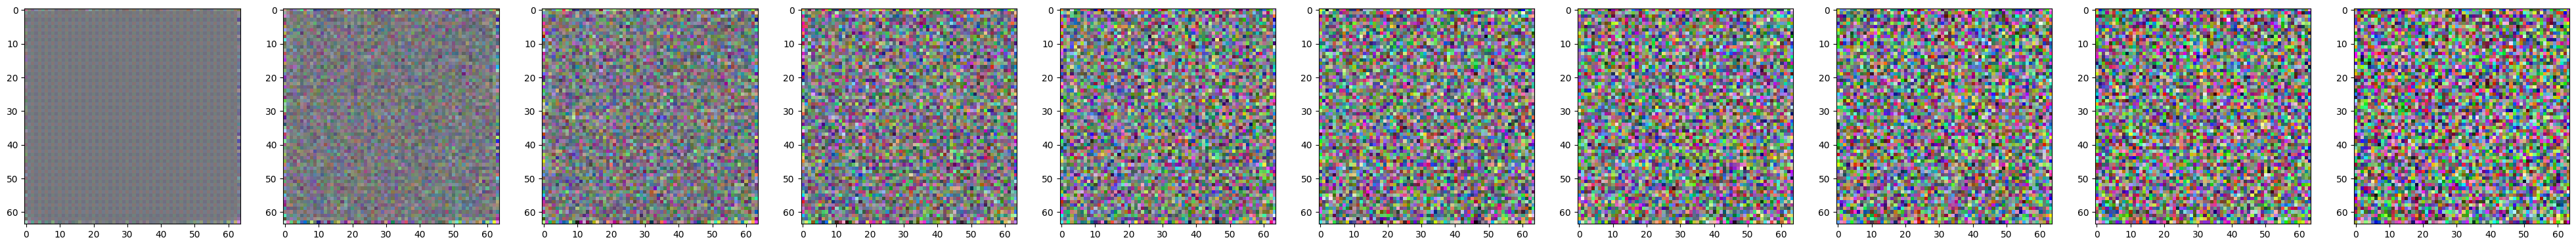

Epoch 70/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 70 | step 000 Loss: 0.12998676300048828 


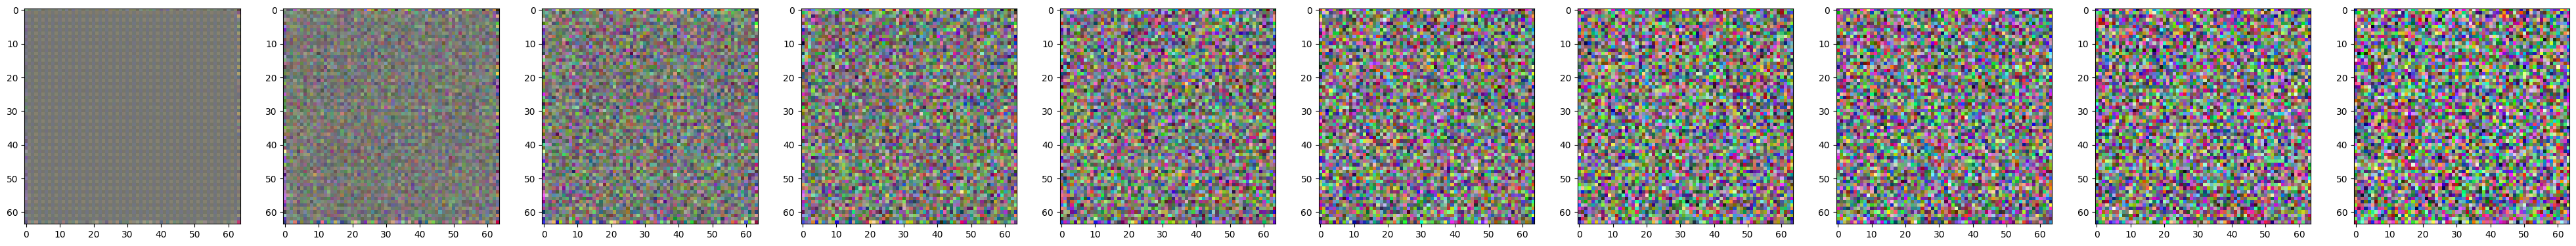

Epoch 75/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 75 | step 000 Loss: 0.11890947073698044 


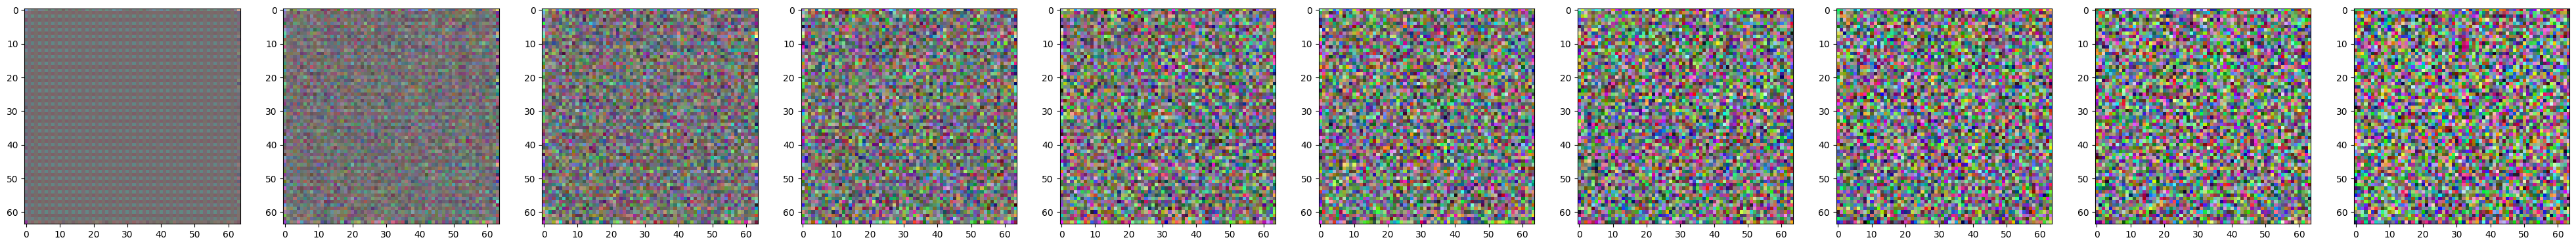

Epoch 80/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 80 | step 000 Loss: 0.11406625807285309 


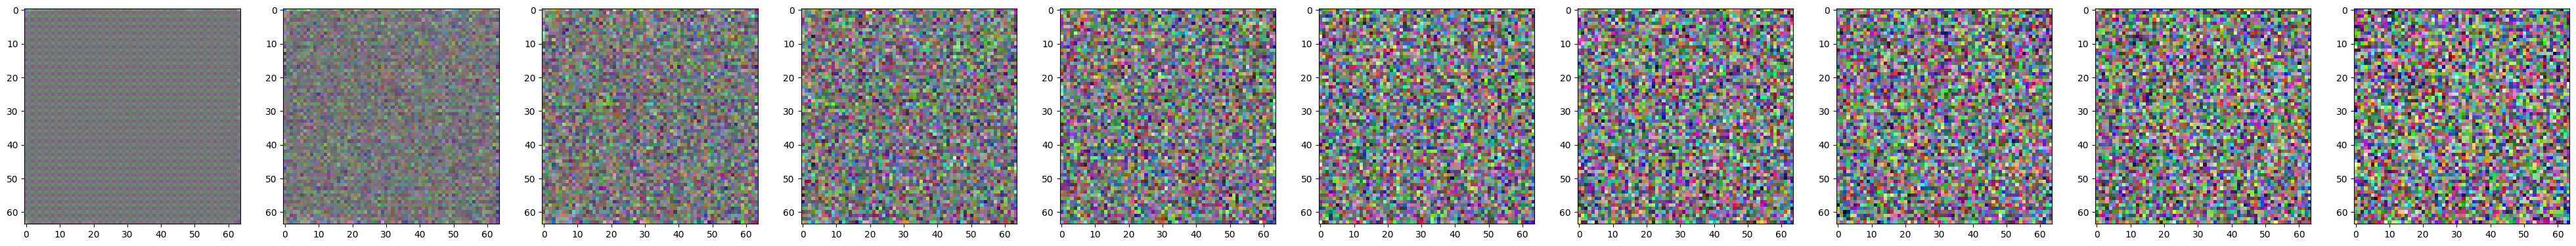

Epoch 85/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 85 | step 000 Loss: 0.11268392205238342 


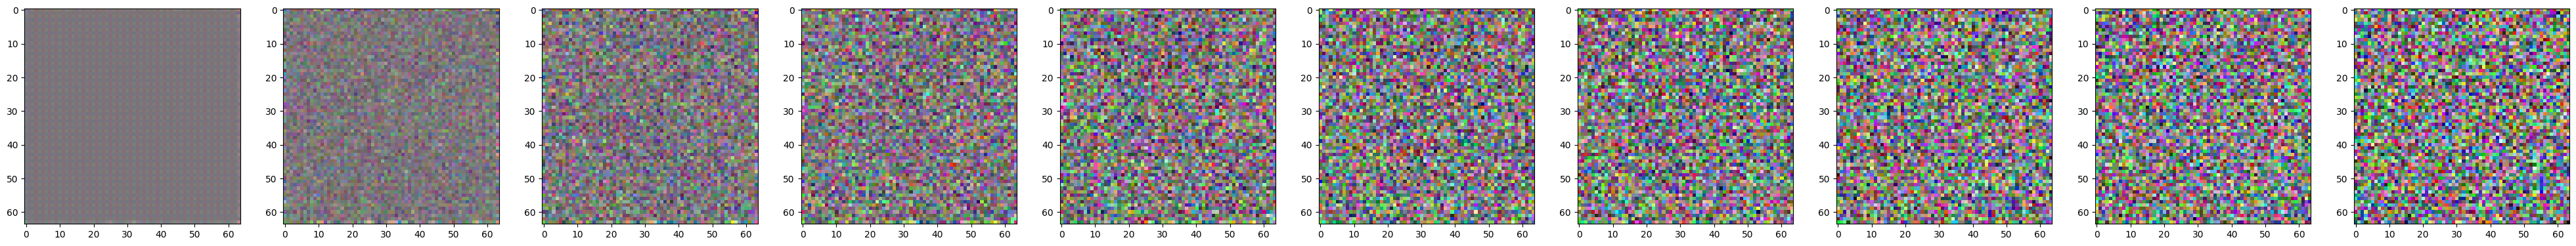

Epoch 90/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 90 | step 000 Loss: 0.1149129867553711 


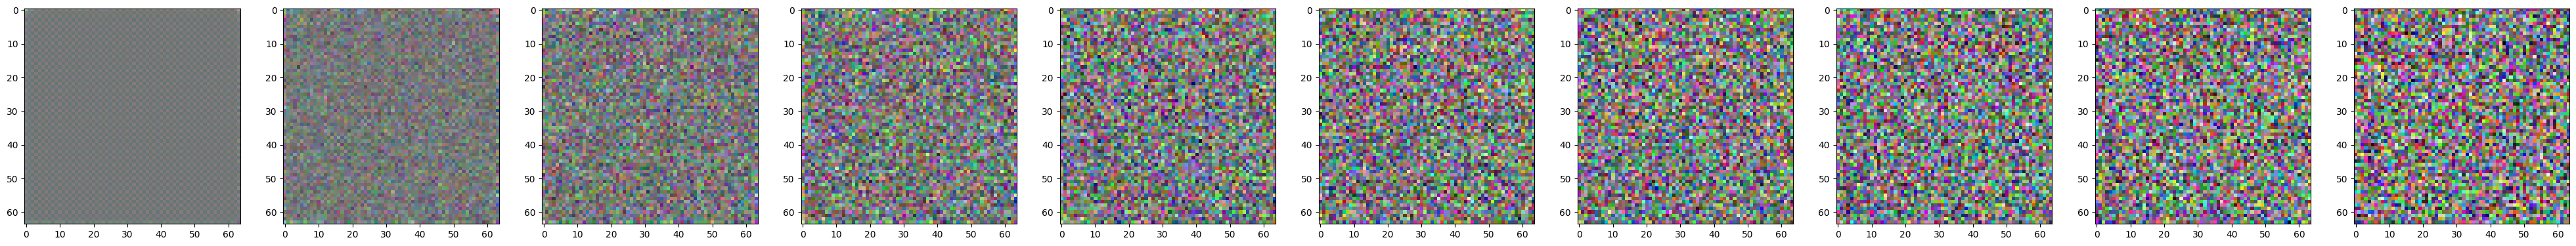

Epoch 95/100:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 95 | step 000 Loss: 0.10538983345031738 


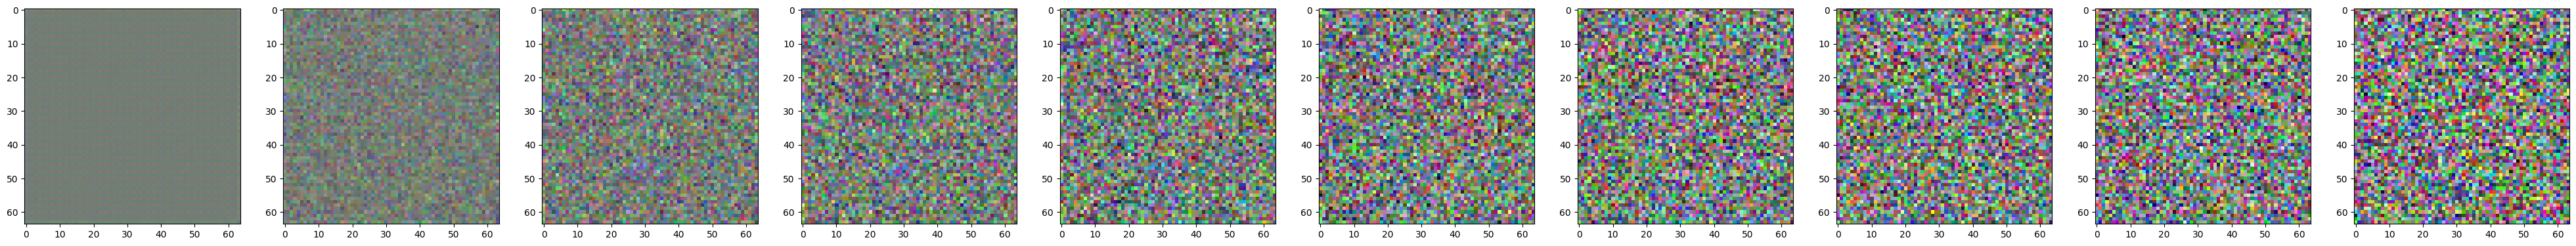

Epoch 99/100: 100%|██████████| 28/28 [00:04<00:00,  6.85it/s]


In [ ]:
from torch.optim import Adam, SGD

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
      optimizer.zero_grad()
      batch_size = int(batch.shape[0])
      t = torch.randint(0, T, (batch_size,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

On Epoch 6 : Loss = 0.17


<ipython-input-74-40631505f403>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

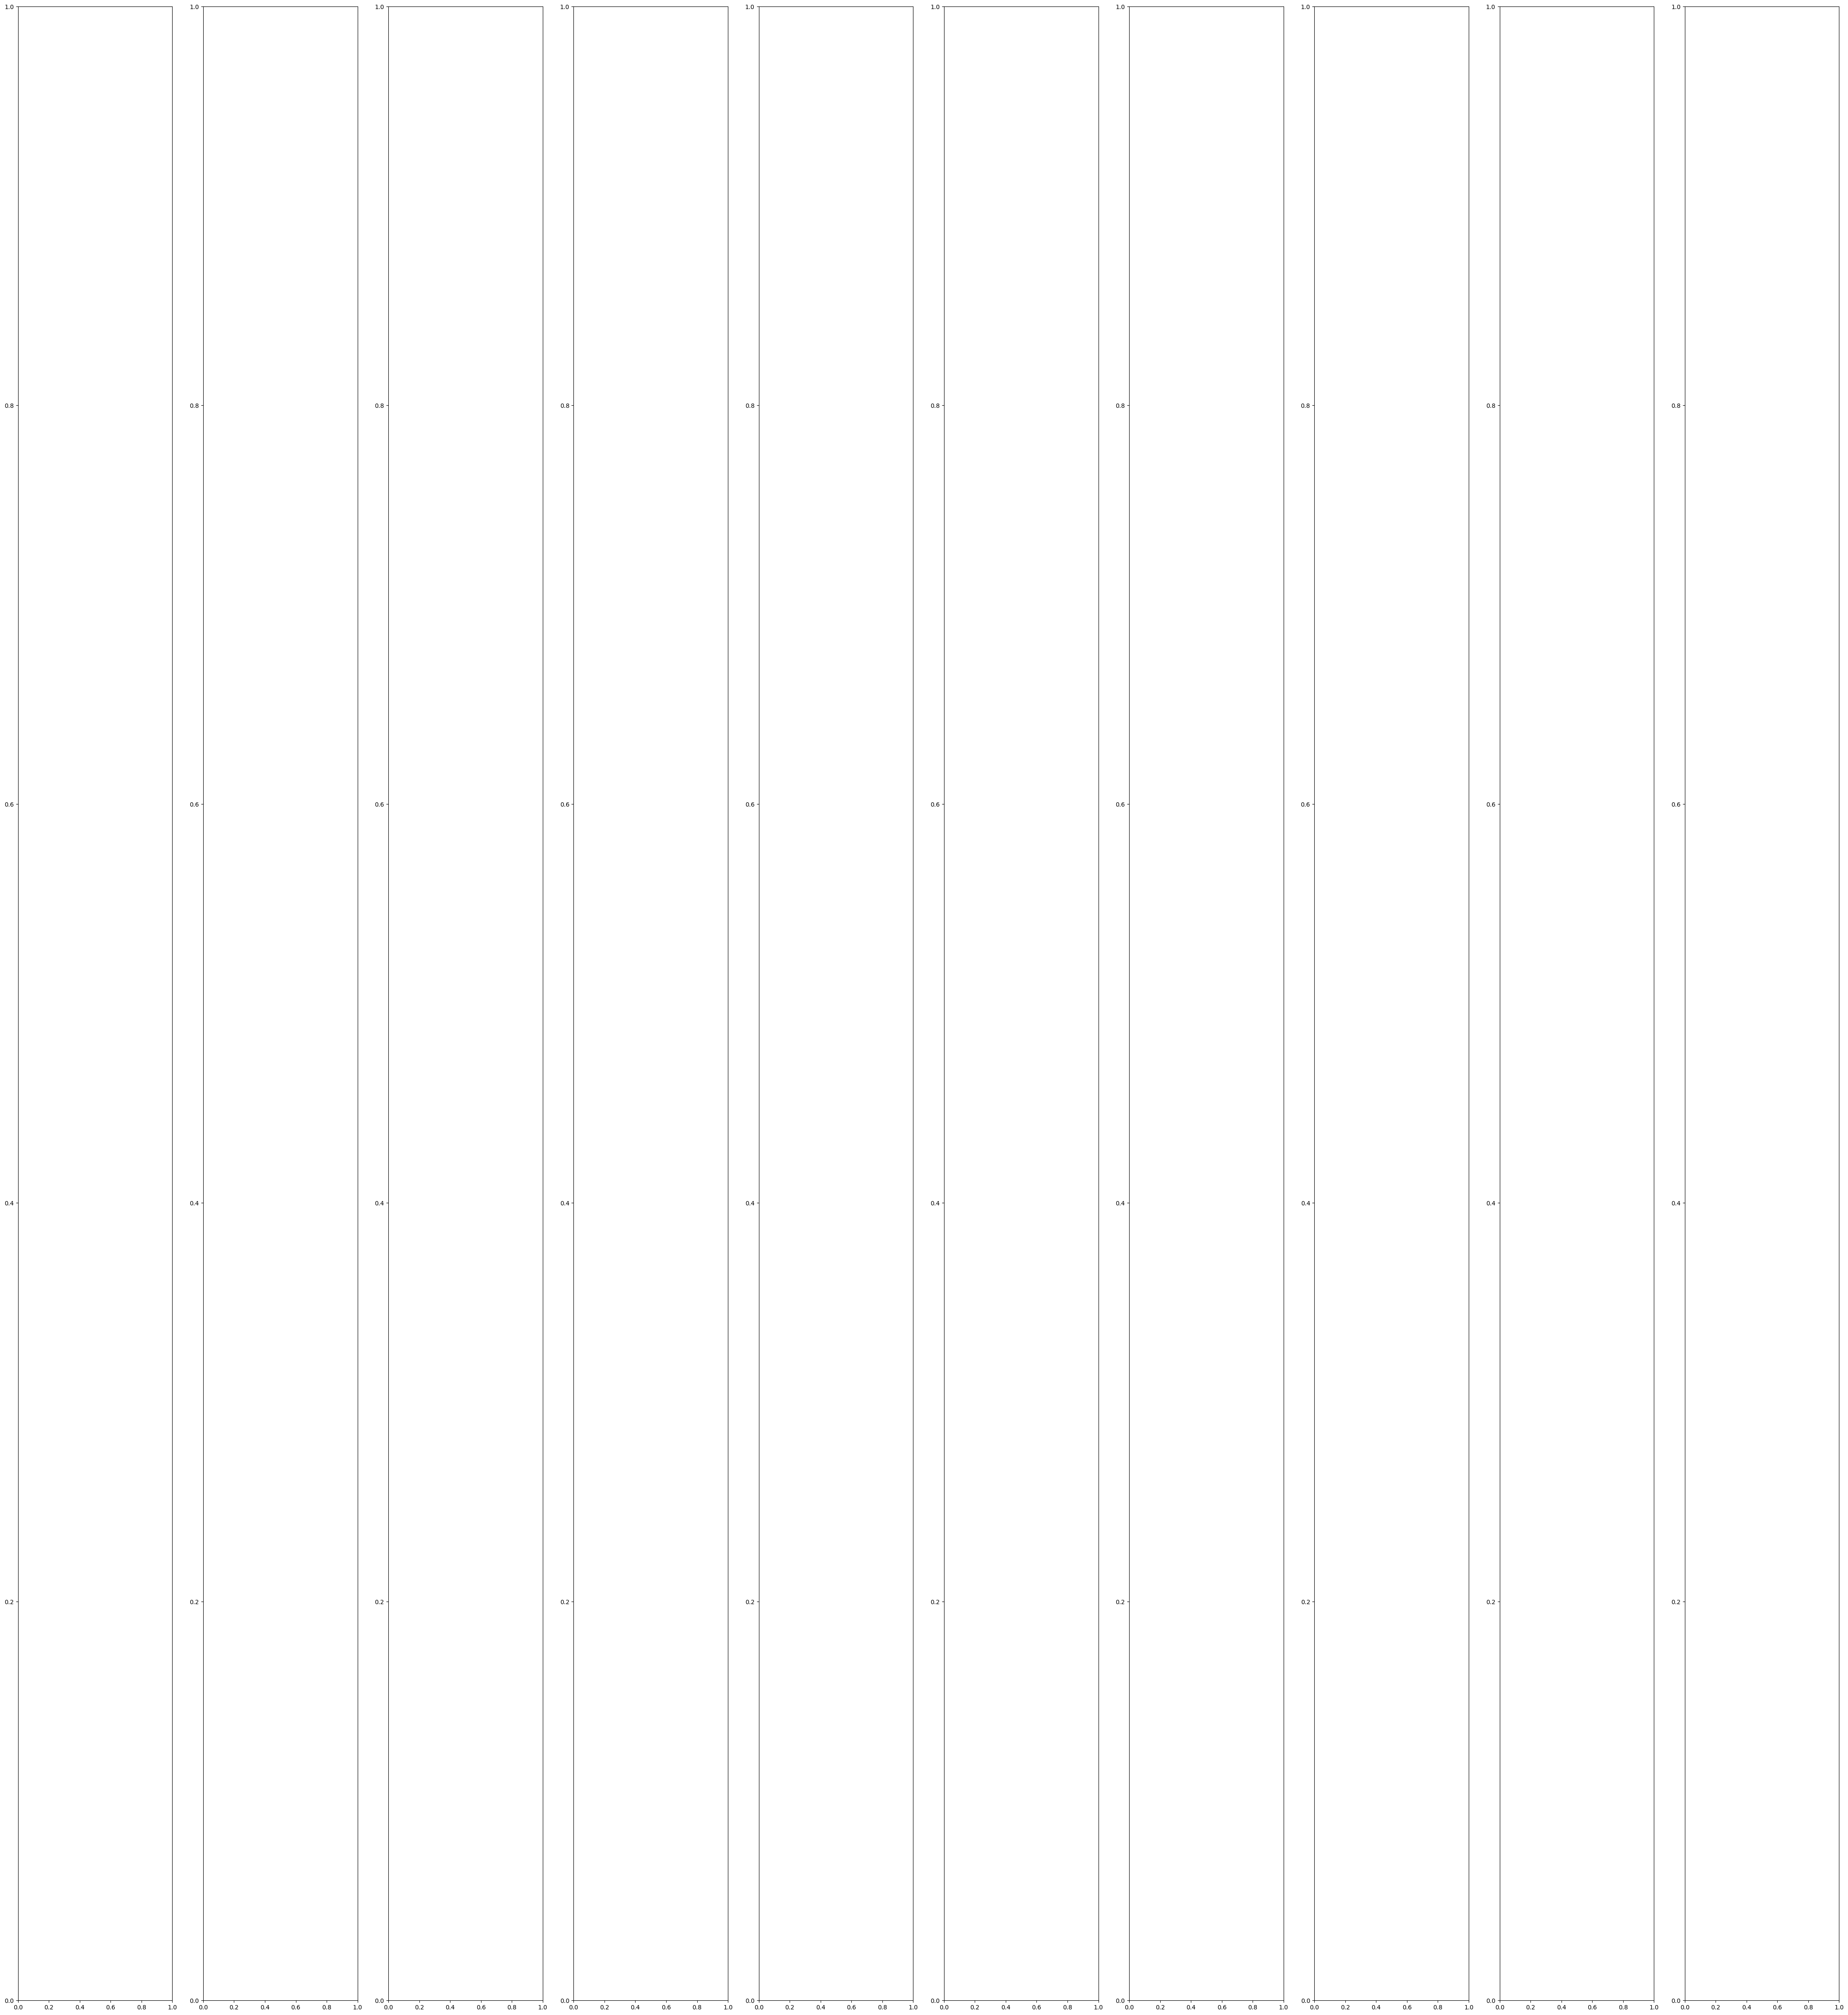

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `model` is your trained SimpleUnet model and `train_loader` is your DataLoader for the training dataset
dataiter = iter(train_loader)
images = next(dataiter)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Select the first image from the batch
image = images[0].to(device)
#print(image.device)

plt.figure(figsize=(60,60))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)


for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t) # Assuming forward_diffusion_sample is defined elsewhere
   # show_tensor_image(img)


# for i in range(0,T)[::-1]:
#     t = torch.full((1,), i, device=device, dtype=torch.long)
#     img = sample_timestep(img, t)
#     # Edit: This is to maintain the natural range of the distribution
#     img = torch.clamp(img, -1.0, 1.0)
#     if i % stepsize == 0:
#         plt.subplot(1, num_images, int(i/stepsize)+1)
#         show_tensor_image(img.detach().cpu())



# #show_tensor_image(image)
t = torch.tensor([0], device=device)  # Ensure `t` is on the same device as `image`
# plt.subplot(1, num_images+1, 1)

#recon = sample_timestep(image, t).to(device)
# show_tensor_image(recon.detach().cpu())



# img = img.to(device)  # Move `img` to the same device as `image`
# #show_tensor_image(noise)


#recon = sample_timestep(img, t)
#show_tensor_image(recon.detach().cpu())
# print(t.device)
# print(image.device)
# print(img.device)
#sample_timestep(img, t)

# # # Assuming `timestep` is a tensor representing the current timestep for the model
# # # For simplicity, let's assume it's a tensor of zeros with the same batch size as the image
# timestep = torch.zeros_like(image[0:1, 0, 0]).to(device)

#  # Reconstruct the image
# model.eval() # Set the model to evaluation mode
# with torch.no_grad(): # Disable gradient computation for efficiency
#      reconstructed_image = model(image.unsqueeze(0), timestep).to(device)

 # Scale the reconstructed image by 255.0 and convert to numpy
# reconstructed_image_scaled = reconstructed_image.squeeze().detach().cpu().numpy() * 255.0

# # Plot original image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
# plt.title('Original Image')
# plt.axis('off')

# # Plot reconstructed image
# plt.subplot(1, 2, 2)
# plt.imshow(np.transpose(reconstructed_image_scaled, (1, 2, 0)))
# plt.title('Reconstructed Image')
# plt.axis('off')

plt.show()
